# 1. Download Data (10 point)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

--2019-05-27 22:09:47--  http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6087523606 (5.7G) [application/zip]
Saving to: ‘MRNet-v1.0.zip’

MRNet-v1.0.zip      100%[===================>]   5.67G  17.6MB/s    in 5m 11s  

2019-05-27 22:14:58 (18.7 MB/s) - ‘MRNet-v1.0.zip’ saved [6087523606/6087523606]



In [0]:
!unzip MRNet-v1.0.zip

Data Description
-----
1250 total data  
1050 training  
120 validation  
3 Classification Classes : ACL, Abnormal, Meniscus (labels are found in .csv true of false)  
3 different imagings for each data : Sagittal, Axial, Coronal
each imaging is an .npy file with format (slices,256,256)

(28, 256, 256)


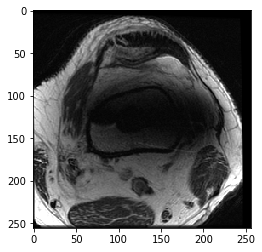

In [0]:
# printing an .npy file as image
import numpy as np
from matplotlib import pyplot as plt


img_array = np.load('MRNet-v1.0/train/axial/1101.npy')

print(img_array.shape)
plt.imshow(img_array[4], cmap='gray')
plt.show()

In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
import seaborn as sns
from torch import optim
import torch.nn.functional as F
torch.__version__

'1.1.0'

In [0]:
# opening csv files
import csv

y_train_abnormal = []


with open("MRNet-v1.0/train-abnormal.csv") as f:
    reader = csv.reader(f)
    for row in reader:
      y_train_abnormal.append(int(row[1]))

In [0]:
# opening csv files
import csv

y_valid_abnormal = []


with open("MRNet-v1.0/valid-abnormal.csv") as f:
    reader = csv.reader(f)
    for row in reader:
      y_valid_abnormal.append(int(row[1]))

## Sagittal Abnormal Model

In [0]:
import glob, os

train_filenames = []
# run changind directory command only once
os.chdir("MRNet-v1.0/train/sagittal/")
for file in glob.glob("*.npy"):
    train_filenames.append(file)

train_filenames.sort()
os.chdir("../../..")

In [0]:
train_filenames = train_filenames[:650]

In [0]:
import glob, os

valid_filenames = []
# run changind directory command only once
os.chdir("MRNet-v1.0/valid/sagittal/")
for file in glob.glob("*.npy"):
    valid_filenames.append(file)

valid_filenames.sort()       
os.chdir("../../..")

In [0]:
def get_batch_data_train(x_train, batch_size):
  
  train_transforms = transforms.Compose([transforms.ToPILImage(),
                                         transforms.CenterCrop(224),                                        
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])
  
  x_train = x_train[:batch_size-9]
  
  rgb_batch = np.repeat(x_train[..., np.newaxis], 3, -1)

  rgb_batch = rgb_batch.reshape(batch_size-9, 3, 256, 256)
  
  train_data = []
  
  for i in range(batch_size-9):
    train_data.append(train_transforms(rgb_batch[i]))
    
  del rgb_batch
  
  train_data = torch.stack(train_data)

  return train_data

In [0]:
def get_batch_data_valid(x_valid, batch_size):
  
  train_transforms = transforms.Compose([transforms.ToPILImage(),
                                         transforms.CenterCrop(224),                                        
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])
  
  rgb_batch = np.repeat(x_valid[..., np.newaxis], 3, -1)

  rgb_batch = rgb_batch.reshape(batch_size, 3, 256, 256)
  
  train_data = []
  
  for i in range(batch_size):
    train_data.append(train_transforms(rgb_batch[i]))
    
  train_data = torch.stack(train_data)
  
  del rgb_batch
  
  return train_data

In [0]:
os.chdir("MRNet-v1.0/train/sagittal/")
x_train = []
for file in train_filenames:
    imgs = np.load(file)
    s = len(imgs)
    x_train.append(get_batch_data_train(np.load(file), s))
os.chdir("../../..")

In [0]:
n = len(x_train)

In [0]:
os.chdir("../../..")

In [0]:
def plots(training_loss, validation_loss, acc, f1_scores, ep):
  # Losses plotting
  plt.plot(ep, training_loss)
  plt.plot(ep, validation_loss)
  plt.legend(['training_loss', 'validation_loss'], loc='upper right')
  plt.title("Losses vs epochs")
  plt.show()
  
  # Accuracy plotting
  plt.plot(ep, acc)
  plt.title("Accuracy vs epochs")
  plt.show()
  
  # f1_scores plotting
  plt.plot(ep, f1_scores)
  plt.title("f1_score vs epochs")
  plt.show()                                      

In [0]:
from sklearn.metrics import f1_score

def train_valid(e, model, x_train, valid_filenames, y_train, y_valid, scheduler, criterion, device, optimizer, valid_path, model_name, batches):
  # Training loop
  epochs = e
  
  acc = []
  training_loss = []
  validation_loss = []
  f_scores = []
  ep = []
  pred = []
  lb = []
  valid_loss_min = np.Inf # track change in validation loss

  
  for epoch in range(epochs):
    
    ep.append(epoch)
    train_loss = 0.0
    valid_loss = 0.0

    accuracy = 0.0
    size_train = 0
    size_valid = 0
    step = 0
    
    # Training mode
    model.train()
    
    for imgs in x_train:
      
      # count the size of the data
      size_train += len(imgs)

      labels = np.array([y_train[step]]) * 1
      labels = torch.FloatTensor(labels)

      # clear variables
      optimizer.zero_grad()
      
      # Put the images and labels to the CUDA GPU
      imgs = imgs.to(device, dtype=torch.float)
      labels = labels.type(torch.FloatTensor)
      labels = labels.to(device, dtype=torch.long)
      
      # forward pass
      output = model(imgs)

      # calculate loss
      loss = criterion(output, labels)

      # backward pass
      loss.backward()

      # perform optimization step
      optimizer.step()

      #update loss
      # Track the accuracy
      train_loss += loss.item() 
      
      step += 1

    correct_predictions = 0.0
    
    # Evaluation mode for the network
    model.eval()
    step = 0
    pred = []
    lb = []
    for file in valid_filenames:
        
        img_array = np.load(file)
        l = len(img_array)
        size_valid += l
        
        imgs = get_batch_data_valid(img_array, l)
        labels = np.array([y_valid[step]]) * 1
        lb.append(y_valid[step])
        labels = torch.FloatTensor(labels)

        #clear variables
        optimizer.zero_grad()

        imgs  = imgs.to(device=device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(imgs)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        labels = labels.reshape(1, -1)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device=device, dtype=torch.long)
        valid_loss += loss.item() 
        predictions = torch.max(output, 1)[1]
        pred.append(predictions.item())
        
        predictions = predictions.type(torch.DoubleTensor)
        predictions = predictions.to(device, dtype=torch.long)
        correct_predictions += torch.sum(predictions == labels.data)
        step += 1
        
    train_loss = train_loss / batches
    valid_loss = valid_loss / 120
    accuracy = correct_predictions.double() / 120
    
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    acc.append(accuracy.item())
    f_scores.append(f1_score(pred, lb))
    
    
    # Stepping the scheduler
    scheduler.step(valid_loss)

    # print training/validation statistics
    print("Epochs : {}/{}".format(epoch+1,epochs),
              "Training Loss : {:.5f}".format(train_loss),
              "Validation Loss : {:.5f}".format(valid_loss),
               "Accuracy : {:.5f}%".format(accuracy*100))

    # Early stopping
    if valid_loss >= train_loss:
        break
        
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      os.chdir("../../..")
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), model_name+'.pt')
      valid_loss_min = valid_loss
      os.chdir(valid_path)
  
  return training_loss, validation_loss, acc, f_scores, ep

In [0]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1) 
        self.classifier = nn.Sequential(OrderedDict([
                          ('dropout', nn.Dropout(p=0.5)),
                          ('fc1', nn.Linear(256, 256)),
#                           ('relu', nn.ReLU()),
#                           ('dropout', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(256, 2)),
#                           ('relu', nn.ReLU()),
#                           ('dropout', nn.Dropout(p=0.5)),
#                           ('fc3', nn.Linear(64, 2)),
                          ]))
        
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        x = F.log_softmax(x)
        return x
      
model = MRNet()

In [0]:
# Freezing Pretrained model layers
for param in model.model.parameters():
      param.requires_grad = False

## Building Our classifier and appending it to the model


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Moving the model to GPU if available
model.to(device)

MRNet(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=9216, out_features=40

In [0]:
from torch import optim

# Defining loss function
criterion = nn.NLLLoss()
# Defining optimizer and using adam optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0008)
# Defining the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [0]:
os.chdir("../../..")

In [0]:
os.chdir("MRNet-v1.0/valid/sagittal/")
training_loss, validation_loss, acc, f1_scores, ep = train_valid(20, model, x_train, valid_filenames, y_train_abnormal, y_valid_abnormal, 
            scheduler, criterion, device, optimizer, "MRNet-v1.0/valid/sagittal/", "sagittal_abnormal", n)
os.chdir("../../..")

Epochs : 1/20 Training Loss : 0.51193 Validation Loss : 0.47118 Accuracy : 80.83333%
Validation loss decreased (inf --> 0.471179).  Saving model ...
Epochs : 2/20 Training Loss : 0.51741 Validation Loss : 0.47023 Accuracy : 81.66667%
Validation loss decreased (0.471179 --> 0.470227).  Saving model ...
Epochs : 3/20 Training Loss : 0.51048 Validation Loss : 0.47217 Accuracy : 80.00000%
Epochs : 4/20 Training Loss : 0.49842 Validation Loss : 0.46910 Accuracy : 80.00000%
Validation loss decreased (0.470227 --> 0.469104).  Saving model ...
Epochs : 5/20 Training Loss : 0.48271 Validation Loss : 0.47471 Accuracy : 79.16667%
Epochs : 6/20 Training Loss : 0.48482 Validation Loss : 0.47063 Accuracy : 80.00000%
Epochs : 7/20 Training Loss : 0.48915 Validation Loss : 0.47335 Accuracy : 81.66667%
Epochs : 8/20 Training Loss : 0.48392 Validation Loss : 0.47697 Accuracy : 82.50000%
Epochs : 9/20 Training Loss : 0.49807 Validation Loss : 0.47202 Accuracy : 82.50000%
Epochs : 10/20 Training Loss : 0.

In [0]:
state_dict = torch.load('sagittal_abnormal.pt')

In [0]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
  name = k.replace(".module", "")
  new_state_dict[name] = v

In [0]:
new_state_dict

In [0]:
model.load_state_dict(new_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
model.state_dict()

In [0]:
model.load_state_dict(torch.load('sagittal_abnormal.pt'))

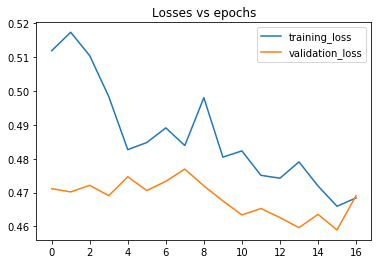

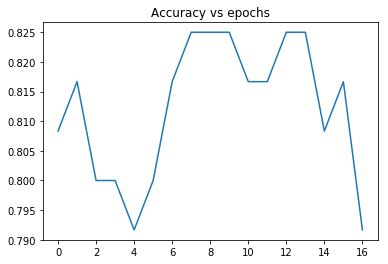

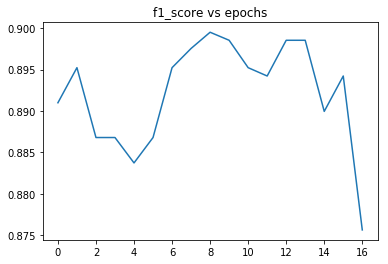

In [0]:
plots(training_loss, validation_loss, acc, f1_scores, ep)

## Axial abnormal Model



In [0]:
import glob, os

train_filenames = []
# run changind directory command only once
os.chdir("MRNet-v1.0/train/axial/")
for file in glob.glob("*.npy"):
    train_filenames.append(file)

train_filenames.sort()
os.chdir("../../..")

In [0]:
train_filenames = train_filenames[:660]

In [0]:
import glob, os

valid_filenames = []
# run changind directory command only once
os.chdir("MRNet-v1.0/valid/axial/")
for file in glob.glob("*.npy"):
    valid_filenames.append(file)

valid_filenames.sort()       
os.chdir("../../..")

In [0]:
os.chdir("MRNet-v1.0/train/axial/")
x_train = []
for file in train_filenames:
    imgs = np.load(file)
    s = len(imgs)
    x_train.append(get_batch_data_train(np.load(file), s))
os.chdir("../../..")

In [0]:
n = len(x_train)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
os.chdir("MRNet-v1.0/valid/axial/")
training_loss, validation_loss, acc, f1_scores, ep = train_valid(20, model, x_train, valid_filenames, y_train_abnormal, y_valid_abnormal, 
            scheduler, criterion, device, optimizer, "MRNet-v1.0/valid/axial/", "axial_abnormal", n)
os.chdir("../../..")

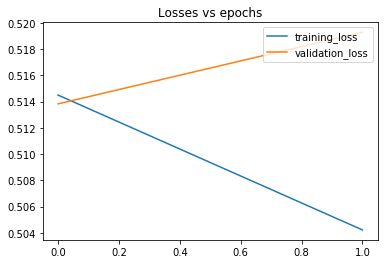

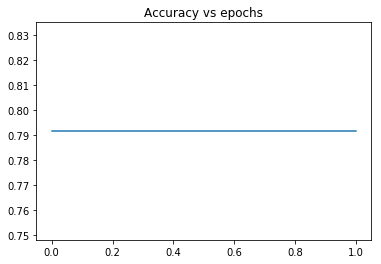

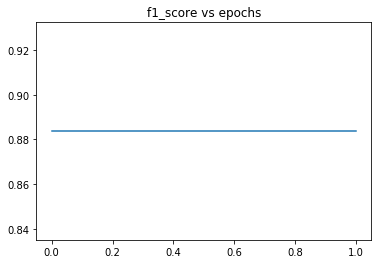

In [0]:
plots(training_loss, validation_loss, acc, f1_scores, ep)

## Coronal abnormal Model


In [0]:
import glob, os

train_filenames = []
# run changind directory command only once
os.chdir("MRNet-v1.0/train/coronal/")
for file in glob.glob("*.npy"):
    train_filenames.append(file)

train_filenames.sort()
os.chdir("../../..")

In [0]:
train_filenames = train_filenames[:750]

In [0]:
import glob, os

valid_filenames = []
# run changind directory command only once
os.chdir("MRNet-v1.0/valid/coronal/")
for file in glob.glob("*.npy"):
    valid_filenames.append(file)

valid_filenames.sort()       
os.chdir("../../..")

In [0]:
os.chdir("MRNet-v1.0/train/coronal/")
x_train = []
for file in train_filenames:
    imgs = np.load(file)
    s = len(imgs)
    x_train.append(get_batch_data_train(np.load(file), s))
os.chdir("../../..")

In [0]:
n = len(x_train)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
os.chdir("MRNet-v1.0/valid/coronal/")
training_loss, validation_loss, acc, f1_scores, ep = train_valid(20, model, x_train, valid_filenames, y_train_abnormal, y_valid_abnormal, 
            scheduler, criterion, device, optimizer, "MRNet-v1.0/valid/coronal/", "coronal_abnormal", n)
os.chdir("../../..")

Epochs : 1/20 Training Loss : 0.51069 Validation Loss : 0.58861 Accuracy : 79.16667%


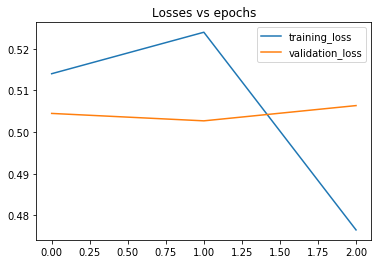

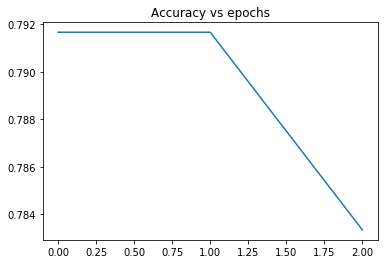

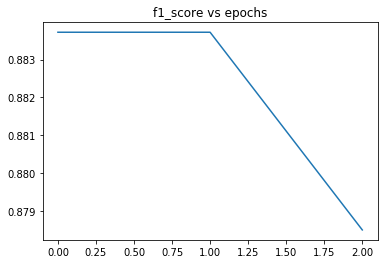

In [0]:
plots(training_loss, validation_loss, acc, f1_scores, ep)

120

array([1, 1, 1])

/content
